In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

from numpy import array
import scipy.sparse

%matplotlib inline

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Load the data

In [2]:
def adapter(indptr, indices, data):
    for i in range(len(indptr), indptr[-1] + 1):
        indptr = np.append(indptr, indptr[-1])
    return (indptr, indices, data)

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')

np.set_printoptions(threshold=np.inf)

# washington_test 2
# indptr = array([0,1,3,4,5,6,7,8,9,9])
# indices = array([1,2,3,4,5,6,6,7,8])
# data = array([1,1,1,1,1,1,1,1,1])

# washington_test 20
indptr = array([0,1,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,81])
indices = array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62])
data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

indptr, indices, data = adapter(indptr, indices, data)

_A_obs = scipy.sparse.csr_matrix((data, indices, indptr), shape=(indptr[-1], indptr[-1]))
print(_A_obs.toarray())

_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0

In [4]:
val_share = 0.1
test_share = 0.05
# seed = 481516234
seed = 12412543

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 8

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [9]:
walker.walk().__next__()

array([[47, 48, 47, 48, 49, 50, 49, 48, 49, 50, 51, 50, 51, 50, 49, 48],
       [43, 42, 30, 42, 24, 42, 31, 42, 34, 14, 34, 42, 36, 42, 34, 14],
       [54, 53, 54, 55, 56, 57, 58, 59, 60, 59, 58, 57, 58, 59, 58, 59],
       [ 5,  1, 19, 39, 19,  1, 14,  1, 18,  1, 18,  1, 10, 30, 10,  1],
       [29, 42, 23, 42, 41, 42, 35, 42, 23, 42, 39, 42, 36, 42, 36, 16],
       [24, 42, 29, 42, 38, 42, 30, 10, 30, 42, 33, 42, 41, 42, 29, 42],
       [34, 42, 40, 42, 25, 42, 36, 16, 36, 16, 36, 16,  1,  3,  1,  2],
       [62, 61, 60, 61, 60, 61, 60, 59, 60, 61, 62, 61, 60, 61, 62, 61]])

#### Create our NetGAN model

In [10]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5, batch_size=batch_size,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

#### Define the stopping criterion

In [11]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [12]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_9.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****
**** Training completed after 119 iterations. ****


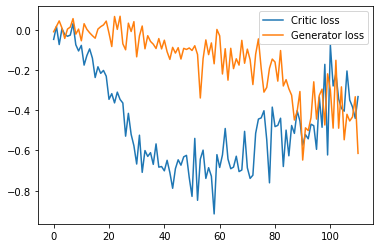

In [13]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=120)

In [14]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

In [15]:
# print(log_dict['val_performances'])
# plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
#          np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
# plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
#          np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

# plt.title("Validation performance during training")
# plt.legend()
# plt.show()

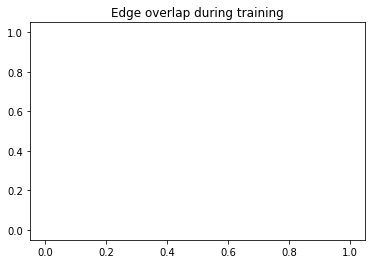

In [16]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [17]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [18]:
samples = []

In [19]:
for _ in range(10):
    if (_+1) % 5 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

4
9


#### Assemble score matrix from the random walks

In [20]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [21]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [22]:
roc_auc_score(test_labels, test_scores)

0.039999999999999994

In [23]:
average_precision_score(test_labels, test_scores)

0.36103174603174604

In [24]:
print(scores_matrix)

  (0, 0)	290.0
  (0, 1)	3055.0
  (0, 2)	200.0
  (0, 3)	122.0
  (0, 4)	253.0
  (0, 5)	392.0
  (0, 6)	236.0
  (0, 7)	259.0
  (0, 8)	253.0
  (0, 9)	254.0
  (0, 10)	374.0
  (0, 11)	199.0
  (0, 12)	271.0
  (0, 13)	516.0
  (0, 14)	427.0
  (0, 15)	255.0
  (0, 16)	336.0
  (0, 17)	403.0
  (0, 18)	403.0
  (0, 19)	317.0
  (0, 20)	425.0
  (0, 21)	369.0
  (0, 22)	219.0
  (0, 23)	211.0
  (0, 24)	163.0
  :	:
  (62, 38)	842.0
  (62, 39)	645.0
  (62, 40)	552.0
  (62, 41)	573.0
  (62, 42)	4295.0
  (62, 43)	826.0
  (62, 44)	873.0
  (62, 45)	385.0
  (62, 46)	1074.0
  (62, 47)	1045.0
  (62, 48)	782.0
  (62, 49)	420.0
  (62, 50)	683.0
  (62, 51)	597.0
  (62, 52)	441.0
  (62, 53)	1107.0
  (62, 54)	611.0
  (62, 55)	945.0
  (62, 56)	614.0
  (62, 57)	663.0
  (62, 58)	633.0
  (62, 59)	1232.0
  (62, 60)	620.0
  (62, 61)	923.0
  (62, 62)	788.0


In [25]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))
print(A_select)

  (0, 1)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
  (1, 4)	1.0
  (1, 5)	1.0
  (1, 6)	1.0
  (1, 7)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 10)	1.0
  (1, 11)	1.0
  (1, 12)	1.0
  (1, 13)	1.0
  (1, 14)	1.0
  (1, 15)	1.0
  (1, 16)	1.0
  (1, 17)	1.0
  (1, 18)	1.0
  (1, 19)	1.0
  (1, 20)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 1)	1.0
  (5, 1)	1.0
  :	:
  (50, 49)	1.0
  (50, 51)	1.0
  (51, 50)	1.0
  (51, 52)	1.0
  (52, 51)	1.0
  (52, 53)	1.0
  (53, 52)	1.0
  (53, 54)	1.0
  (54, 53)	1.0
  (54, 55)	1.0
  (55, 54)	1.0
  (55, 56)	1.0
  (56, 55)	1.0
  (56, 57)	1.0
  (57, 56)	1.0
  (57, 58)	1.0
  (58, 57)	1.0
  (58, 59)	1.0
  (59, 58)	1.0
  (59, 60)	1.0
  (60, 59)	1.0
  (60, 61)	1.0
  (61, 60)	1.0
  (61, 62)	1.0
  (62, 61)	1.0


In [26]:
print(_A_obs)

  (0, 1)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  (1, 12)	1
  (1, 13)	1
  (1, 14)	1
  (1, 15)	1
  (1, 16)	1
  (1, 17)	1
  (1, 18)	1
  (1, 19)	1
  (1, 20)	1
  (1, 21)	1
  (2, 1)	1
  (2, 22)	1
  (3, 1)	1
  :	:
  (50, 49)	1
  (50, 51)	1
  (51, 50)	1
  (51, 52)	1
  (52, 51)	1
  (52, 53)	1
  (53, 52)	1
  (53, 54)	1
  (54, 53)	1
  (54, 55)	1
  (55, 54)	1
  (55, 56)	1
  (56, 55)	1
  (56, 57)	1
  (57, 56)	1
  (57, 58)	1
  (58, 57)	1
  (58, 59)	1
  (59, 58)	1
  (59, 60)	1
  (60, 59)	1
  (60, 61)	1
  (61, 60)	1
  (61, 62)	1
  (62, 61)	1


In [27]:
print(A_select != _A_obs)

  (1, 21)	True
  (2, 22)	True
  (3, 23)	True
  (4, 24)	True
  (5, 25)	True
  (7, 27)	True
  (8, 28)	True
  (9, 29)	True
  (11, 31)	True
  (12, 32)	True
  (15, 35)	True
  (17, 37)	True
  (18, 38)	True
  (21, 1)	True
  (22, 2)	True
  (23, 3)	True
  (24, 4)	True
  (25, 5)	True
  (27, 7)	True
  (28, 8)	True
  (29, 9)	True
  (31, 11)	True
  (32, 12)	True
  (35, 15)	True
  (37, 17)	True
  (38, 18)	True


In [28]:
i = 0
for row in _A_obs.todense():
    row = np.array(row).flatten()
    for j in range(i, len(row)):
        if row[j] > 0:
            print(i+1, j+1, 1)
    i += 1

1 2 1
2 3 1
2 4 1
2 5 1
2 6 1
2 7 1
2 8 1
2 9 1
2 10 1
2 11 1
2 12 1
2 13 1
2 14 1
2 15 1
2 16 1
2 17 1
2 18 1
2 19 1
2 20 1
2 21 1
2 22 1
3 23 1
4 24 1
5 25 1
6 26 1
7 27 1
8 28 1
9 29 1
10 30 1
11 31 1
12 32 1
13 33 1
14 34 1
15 35 1
16 36 1
17 37 1
18 38 1
19 39 1
20 40 1
21 41 1
22 42 1
23 43 1
24 43 1
25 43 1
26 43 1
27 43 1
28 43 1
29 43 1
30 43 1
31 43 1
32 43 1
33 43 1
34 43 1
35 43 1
36 43 1
37 43 1
38 43 1
39 43 1
40 43 1
41 43 1
42 43 1
43 44 1
44 45 1
45 46 1
46 47 1
47 48 1
48 49 1
49 50 1
50 51 1
51 52 1
52 53 1
53 54 1
54 55 1
55 56 1
56 57 1
57 58 1
58 59 1
59 60 1
60 61 1
61 62 1
62 63 1


In [29]:
i = 0
for row in A_select.todense():
    row = np.array(row).flatten()
    for j in range(i, len(row)):
        if row[j] > 0:
            print(i+1, j+1, 1)
    i += 1

1 2 1
2 3 1
2 4 1
2 5 1
2 6 1
2 7 1
2 8 1
2 9 1
2 10 1
2 11 1
2 12 1
2 13 1
2 14 1
2 15 1
2 16 1
2 17 1
2 18 1
2 19 1
2 20 1
2 21 1
7 27 1
11 31 1
14 34 1
15 35 1
17 37 1
20 40 1
21 41 1
22 42 1
23 43 1
24 43 1
25 43 1
26 43 1
27 43 1
28 43 1
29 43 1
30 43 1
31 43 1
32 43 1
33 43 1
34 43 1
35 43 1
36 43 1
37 43 1
38 43 1
39 43 1
40 43 1
41 43 1
42 43 1
43 44 1
44 45 1
45 46 1
46 47 1
47 48 1
48 49 1
49 50 1
50 51 1
51 52 1
52 53 1
53 54 1
54 55 1
55 56 1
56 57 1
57 58 1
58 59 1
59 60 1
60 61 1
61 62 1
62 63 1
